Detailed explanation:
https://medium.com/@alexppppp/how-to-train-a-custom-keypoint-detection-model-with-pytorch-d9af90e111da

GitHub repo:
https://github.com/alexppppp/keypoint_rcnn_training_pytorch



# 1. Imports

In [1]:

!git clone https://github.com/xxBLUECATxx/Simple_Keypoint_Detect.git
%cd Simple_Keypoint_Detect

Cloning into 'Simple_Keypoint_Detect'...
remote: Enumerating objects: 610, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 610 (delta 18), reused 162 (delta 10), pack-reused 434
Receiving objects: 100% (610/610), 52.91 MiB | 30.39 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/Simple_Keypoint_Detect


In [2]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

import albumentations as A # Library for augmentations

In [3]:
# https://github.com/pytorch/vision/tree/main/references/detection
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate


# 1.1 Label your dataset

In [15]:
from google.colab import output
output.serve_kernel_port_as_window(5000)
!python /content/Simple_Keypoint_Detect/labeller/labeller.py

<IPython.core.display.Javascript object>

 * Serving Flask app 'labeller'
 * Debug mode: on
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 479-513-453
127.0.0.1 - - [23/May/2024 05:13:57] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/May/2024 05:13:58] "GET /static/piggy.png HTTP/1.1" 200 -
127.0.0.1 - - [23/May/2024 05:13:59] "GET /favicon.ico HTTP/1.1" 404 -


# 2. Augmentations

In [5]:
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more here https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

# 3. Dataset class

In [6]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "labels")))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "labels", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']

            # All objects are glue tubes
            bboxes_labels_original = ['Glue tube' for _ in bboxes_original]

        if self.transform:
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]

            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']

            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,2,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)

        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original

        # Convert everything into a torch tensor
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are glue tubes
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)

        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target

    def __len__(self):
        return len(self.imgs_files)

# 4. Visualizing a random item from dataset

Original targets:
 ({'boxes': tensor([[ 48.0000,  35.1750, 284.0000, 299.1750]]), 'labels': tensor([1]), 'image_id': tensor([0]), 'area': tensor([62304.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[199.0000, 192.1750,   1.0000],
         [242.0000,  52.1750,   1.0000]]])},) 


Transformed targets:
 ({'boxes': tensor([[116.0000,   0.8250, 352.0000, 264.8250]]), 'labels': tensor([1]), 'image_id': tensor([0]), 'area': tensor([62304.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[200.0000, 106.8250,   1.0000],
         [157.0000, 246.8250,   1.0000]]])},)


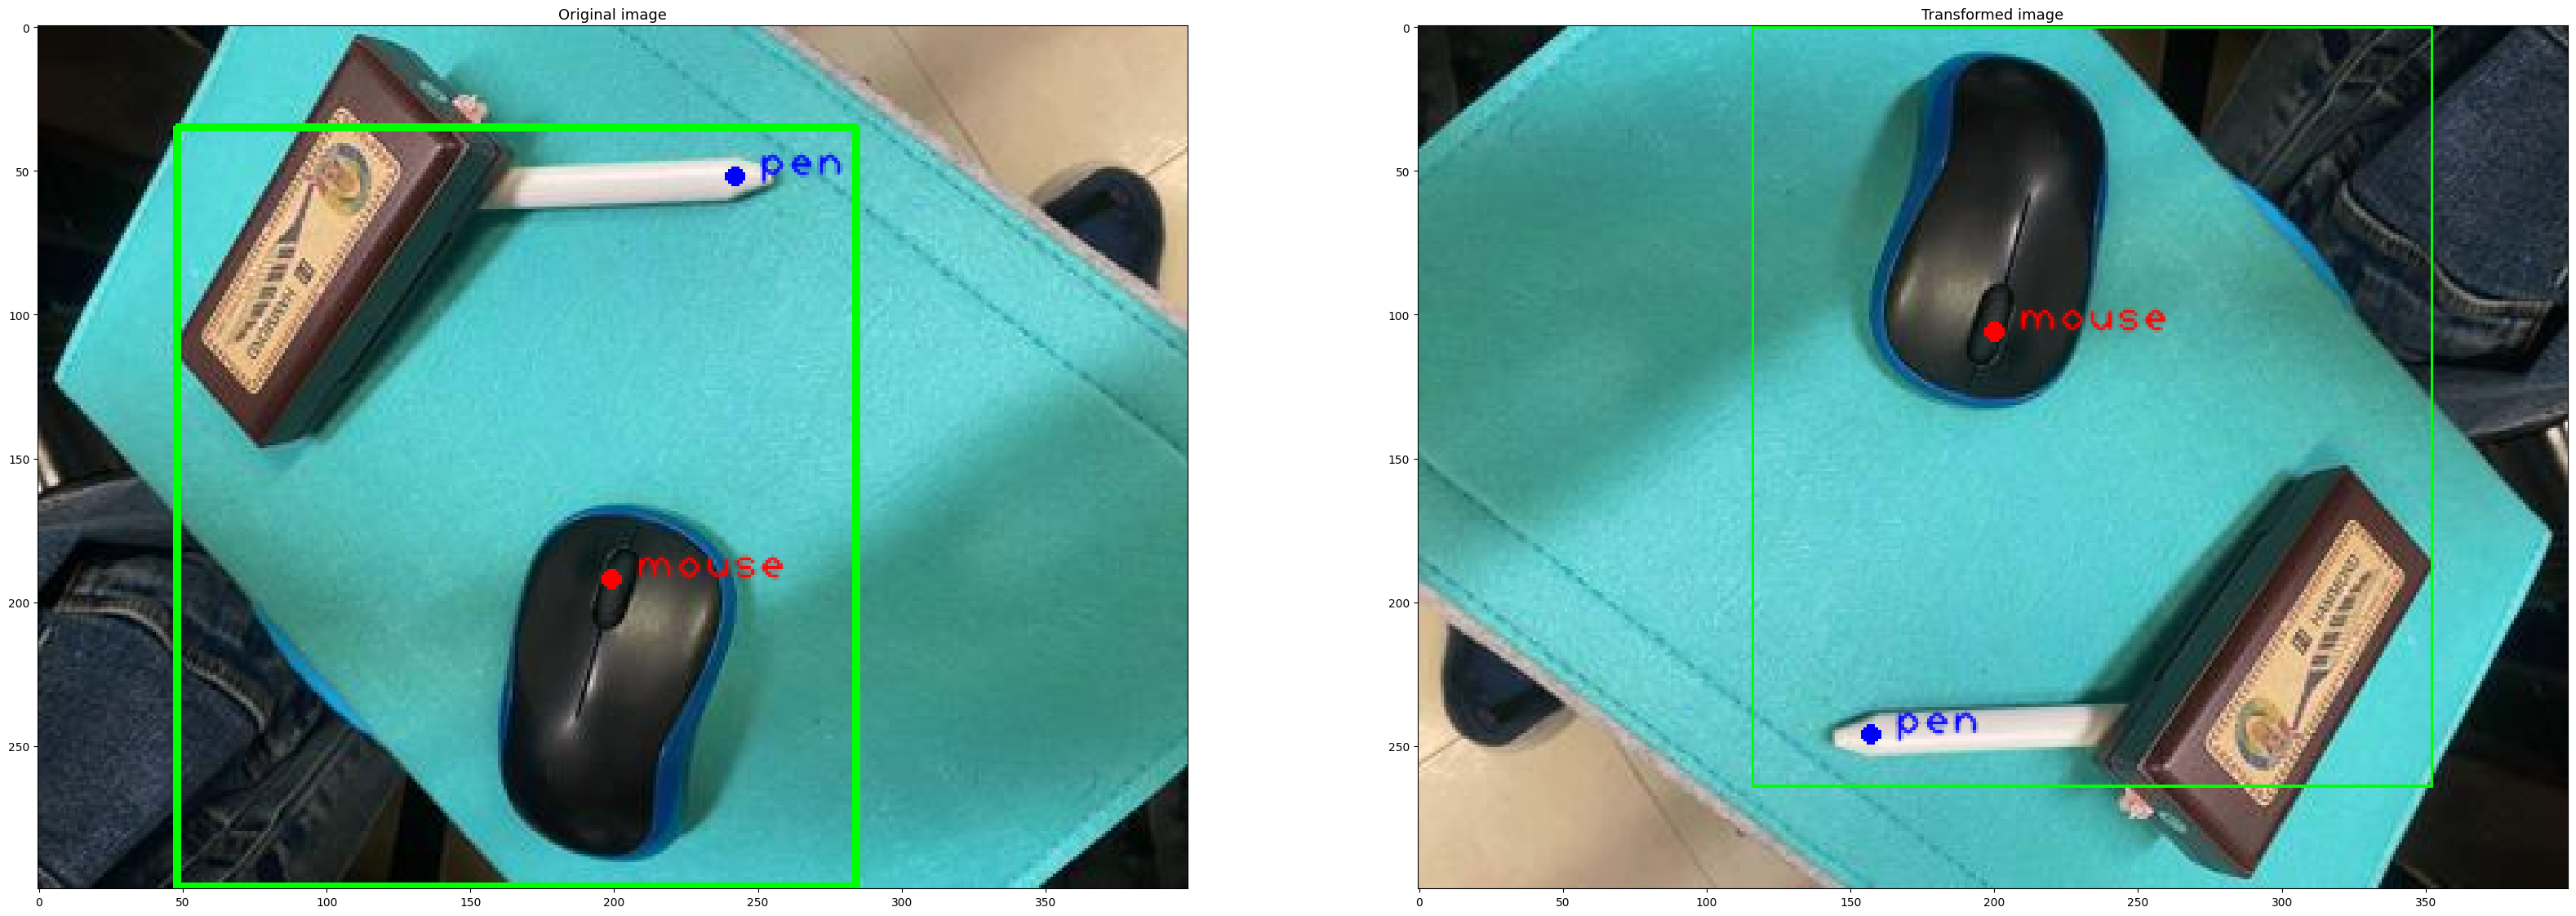

In [24]:
KEYPOINTS_FOLDER_TRAIN = 'my_set/train'
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

print("Original targets:\n", batch[3], "\n\n")
print("Transformed targets:\n", batch[1])

keypoints_classes_ids2names = {0: 'mouse', 1: 'pen'} #Here, you can change the label name according to your own scenario.

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 13

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 1)

    for kps in keypoints:
        n=0
        for idx, kp in enumerate(kps):
          if n ==0:
            image = cv2.circle(image.copy(), tuple(kp), 2, (255,0,0), 2)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 1, cv2.LINE_AA)
          else:
            image = cv2.circle(image.copy(), tuple(kp), 2, (0,0,255), 2)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_PLAIN, 1, (0,0,255), 1, cv2.LINE_AA)
          n+=1

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)

        for kps in keypoints_original:
            n = 0
            for idx, kp in enumerate(kps):
              if n == 0:
                image_original = cv2.circle(image_original, tuple(kp), 2, (255,0,0), 2)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 1, cv2.LINE_AA)
              else:
                image_original = cv2.circle(image_original, tuple(kp), 2, (0,0,255), 2)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_PLAIN, 1, (0,0,255), 1, cv2.LINE_AA)
              n+=1

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

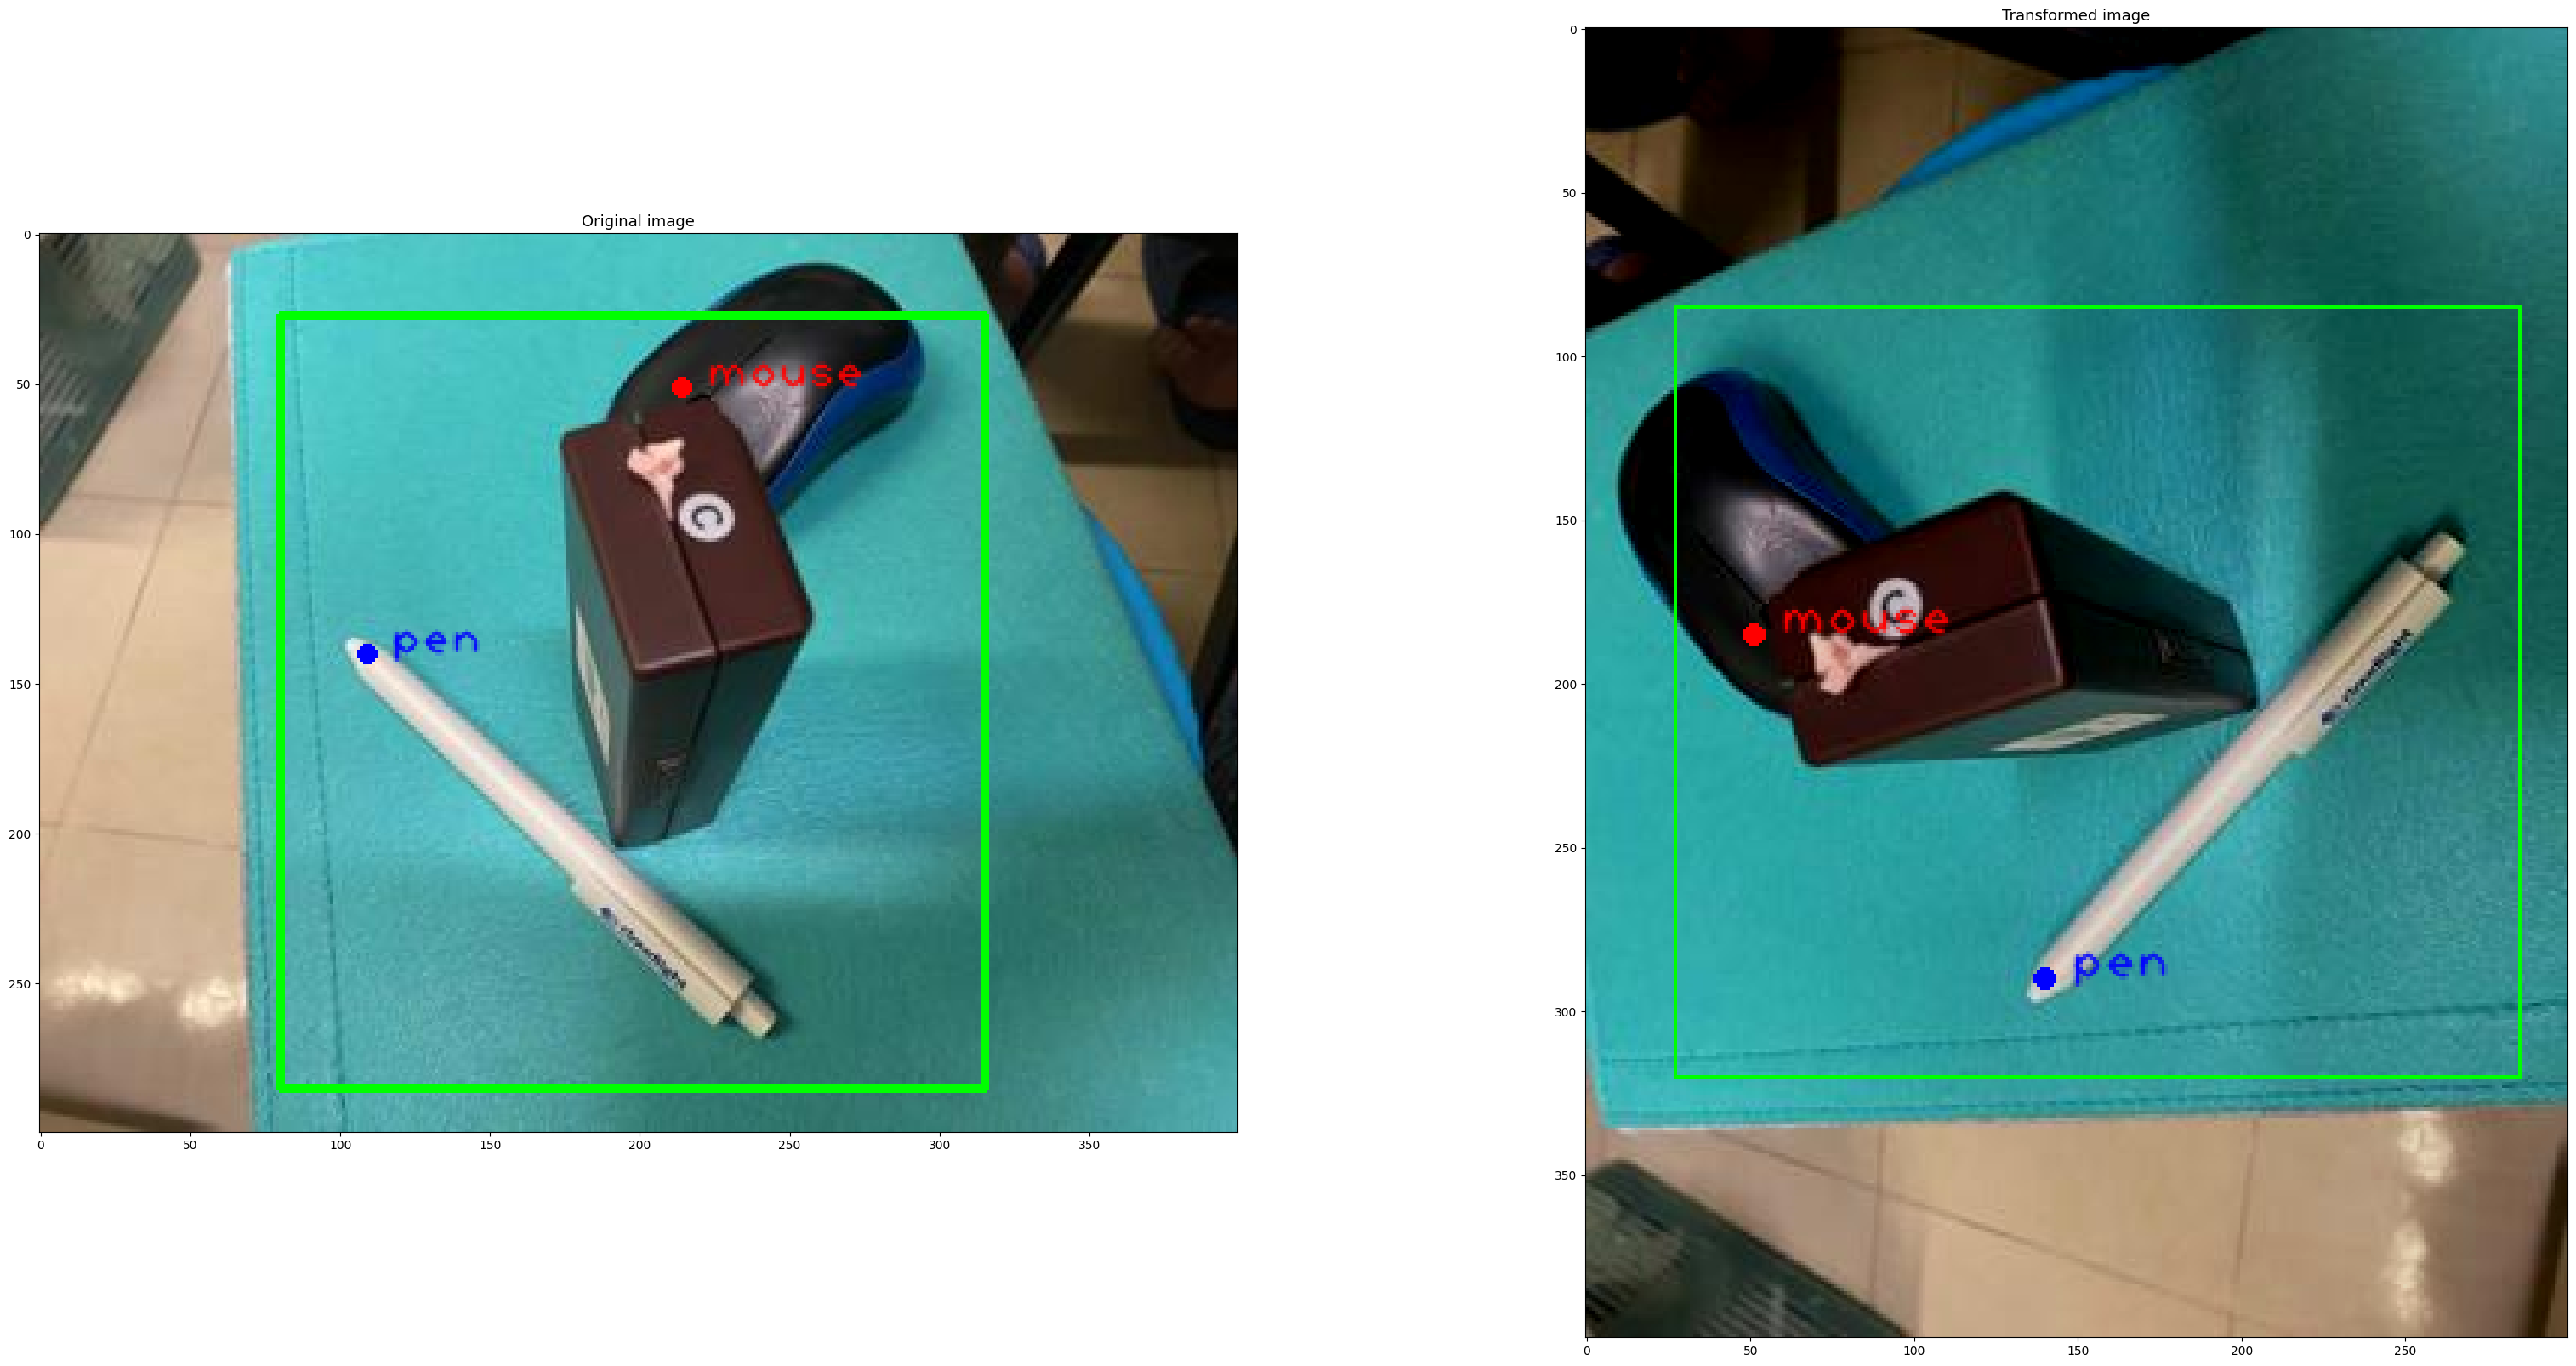

In [20]:
keypoints_classes_ids2names = {0: 'mouse', 1: 'pen'} #Here, you can change the label name according to your own scenario.

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 13

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 1)

    for kps in keypoints:
        n=0
        for idx, kp in enumerate(kps):
          if n ==0:
            image = cv2.circle(image.copy(), tuple(kp), 2, (255,0,0), 2)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 1, cv2.LINE_AA)
          else:
            image = cv2.circle(image.copy(), tuple(kp), 2, (0,0,255), 2)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_PLAIN, 1, (0,0,255), 1, cv2.LINE_AA)
          n+=1

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)

        for kps in keypoints_original:
            n = 0
            for idx, kp in enumerate(kps):
              if n == 0:
                image_original = cv2.circle(image_original, tuple(kp), 2, (255,0,0), 2)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 1, cv2.LINE_AA)
              else:
                image_original = cv2.circle(image_original, tuple(kp), 2, (0,0,255), 2)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_PLAIN, 1, (0,0,255), 1, cv2.LINE_AA)
              n+=1

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

# 5. Training

In [ ]:
def get_model(num_keypoints, weights_path=None):

    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)

    return model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

KEYPOINTS_FOLDER_TRAIN = 'my_set/train'   #Change the dataset to others (Covered keypoints/ Higher Quailiy) to see the changes!
KEYPOINTS_FOLDER_TEST = 'my_set/test'     #Change the dataset to others (Covered keypoints/ Higher Quailiy) to see the changes!

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

model = get_model(num_keypoints = 2)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.3)
num_epochs = 50

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)

# Save model weights after training
torch.save(model.state_dict(), 'keypointsrcnn_weights.pth')

Epoch: [0]  [0/7]  eta: 0:00:03  lr: 0.000017  loss: 9.3071 (9.3071)  loss_classifier: 0.7009 (0.7009)  loss_box_reg: 0.0101 (0.0101)  loss_keypoint: 7.8836 (7.8836)  loss_objectness: 0.6997 (0.6997)  loss_rpn_box_reg: 0.0127 (0.0127)  time: 0.4335  data: 0.0097  max mem: 1582
Epoch: [0]  [6/7]  eta: 0:00:00  lr: 0.000100  loss: 9.1934 (9.1838)  loss_classifier: 0.3176 (0.3704)  loss_box_reg: 0.0101 (0.0204)  loss_keypoint: 8.1540 (8.1018)  loss_objectness: 0.6945 (0.6853)  loss_rpn_box_reg: 0.0049 (0.0060)  time: 0.2695  data: 0.0086  max mem: 1776
Epoch: [0] Total time: 0:00:01 (0.2700 s / it)
creating index...
index created!
Test:  [0/3]  eta: 0:00:00  model_time: 0.2443 (0.2443)  evaluator_time: 0.0212 (0.0212)  time: 0.2702  data: 0.0040  max mem: 1776
Test:  [2/3]  eta: 0:00:00  model_time: 0.3207 (0.3260)  evaluator_time: 0.0281 (0.0328)  time: 0.3722  data: 0.0117  max mem: 1776
Test: Total time: 0:00:01 (0.3745 s / it)
Averaged stats: model_time: 0.3207 (0.3260)  evaluator_tim

# 6. Visualizing model predictions

In [ ]:
iterator = iter(data_loader_test)

In [ ]:
images, targets = next(iterator)
images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

print("Predictions: \n", output)


Predictions: 
 [{'boxes': tensor([[104.1590,  16.4664, 251.1662, 258.1414],
        [123.6356,  84.7179, 399.7753, 258.8600],
        [ 79.3441,   0.0000, 342.9371, 197.9557],
        [ 48.4062,  76.3026, 288.1505, 238.7207],
        [ 83.2810, 125.5963, 305.8580, 292.2646],
        [161.3152,   0.0000, 270.7321, 299.0000],
        [  1.1506, 124.4335, 194.5550, 288.7720],
        [224.0684,  74.9845, 383.4006, 299.0000],
        [ 46.1794,   0.0000, 168.6241, 286.3755],
        [142.9952, 154.9828, 399.8396, 299.0000],
        [  0.0000,  41.9955, 213.8343, 205.0004],
        [128.7132,   0.0000, 400.0000, 136.5551],
        [239.2172,   2.5551, 383.7507, 222.9977],
        [185.6939,  24.8956, 343.2273, 258.9791],
        [  0.0000,   0.0000, 265.4730, 147.4181]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6455, 0.6115, 0.6032, 0.5804, 0.5768, 0.5710, 0.5709, 0.5539, 0.5468,
        0.5386, 0.5252, 0.5144, 0

[0.64551485 0.611458   0.6031594  0.58043534 0.5767595  0.5710332
 0.57093126 0.55385065 0.54683936 0.5386105  0.5251778  0.5143544
 0.50365806 0.46010685 0.42126355]
[[104, 16, 251, 258]]


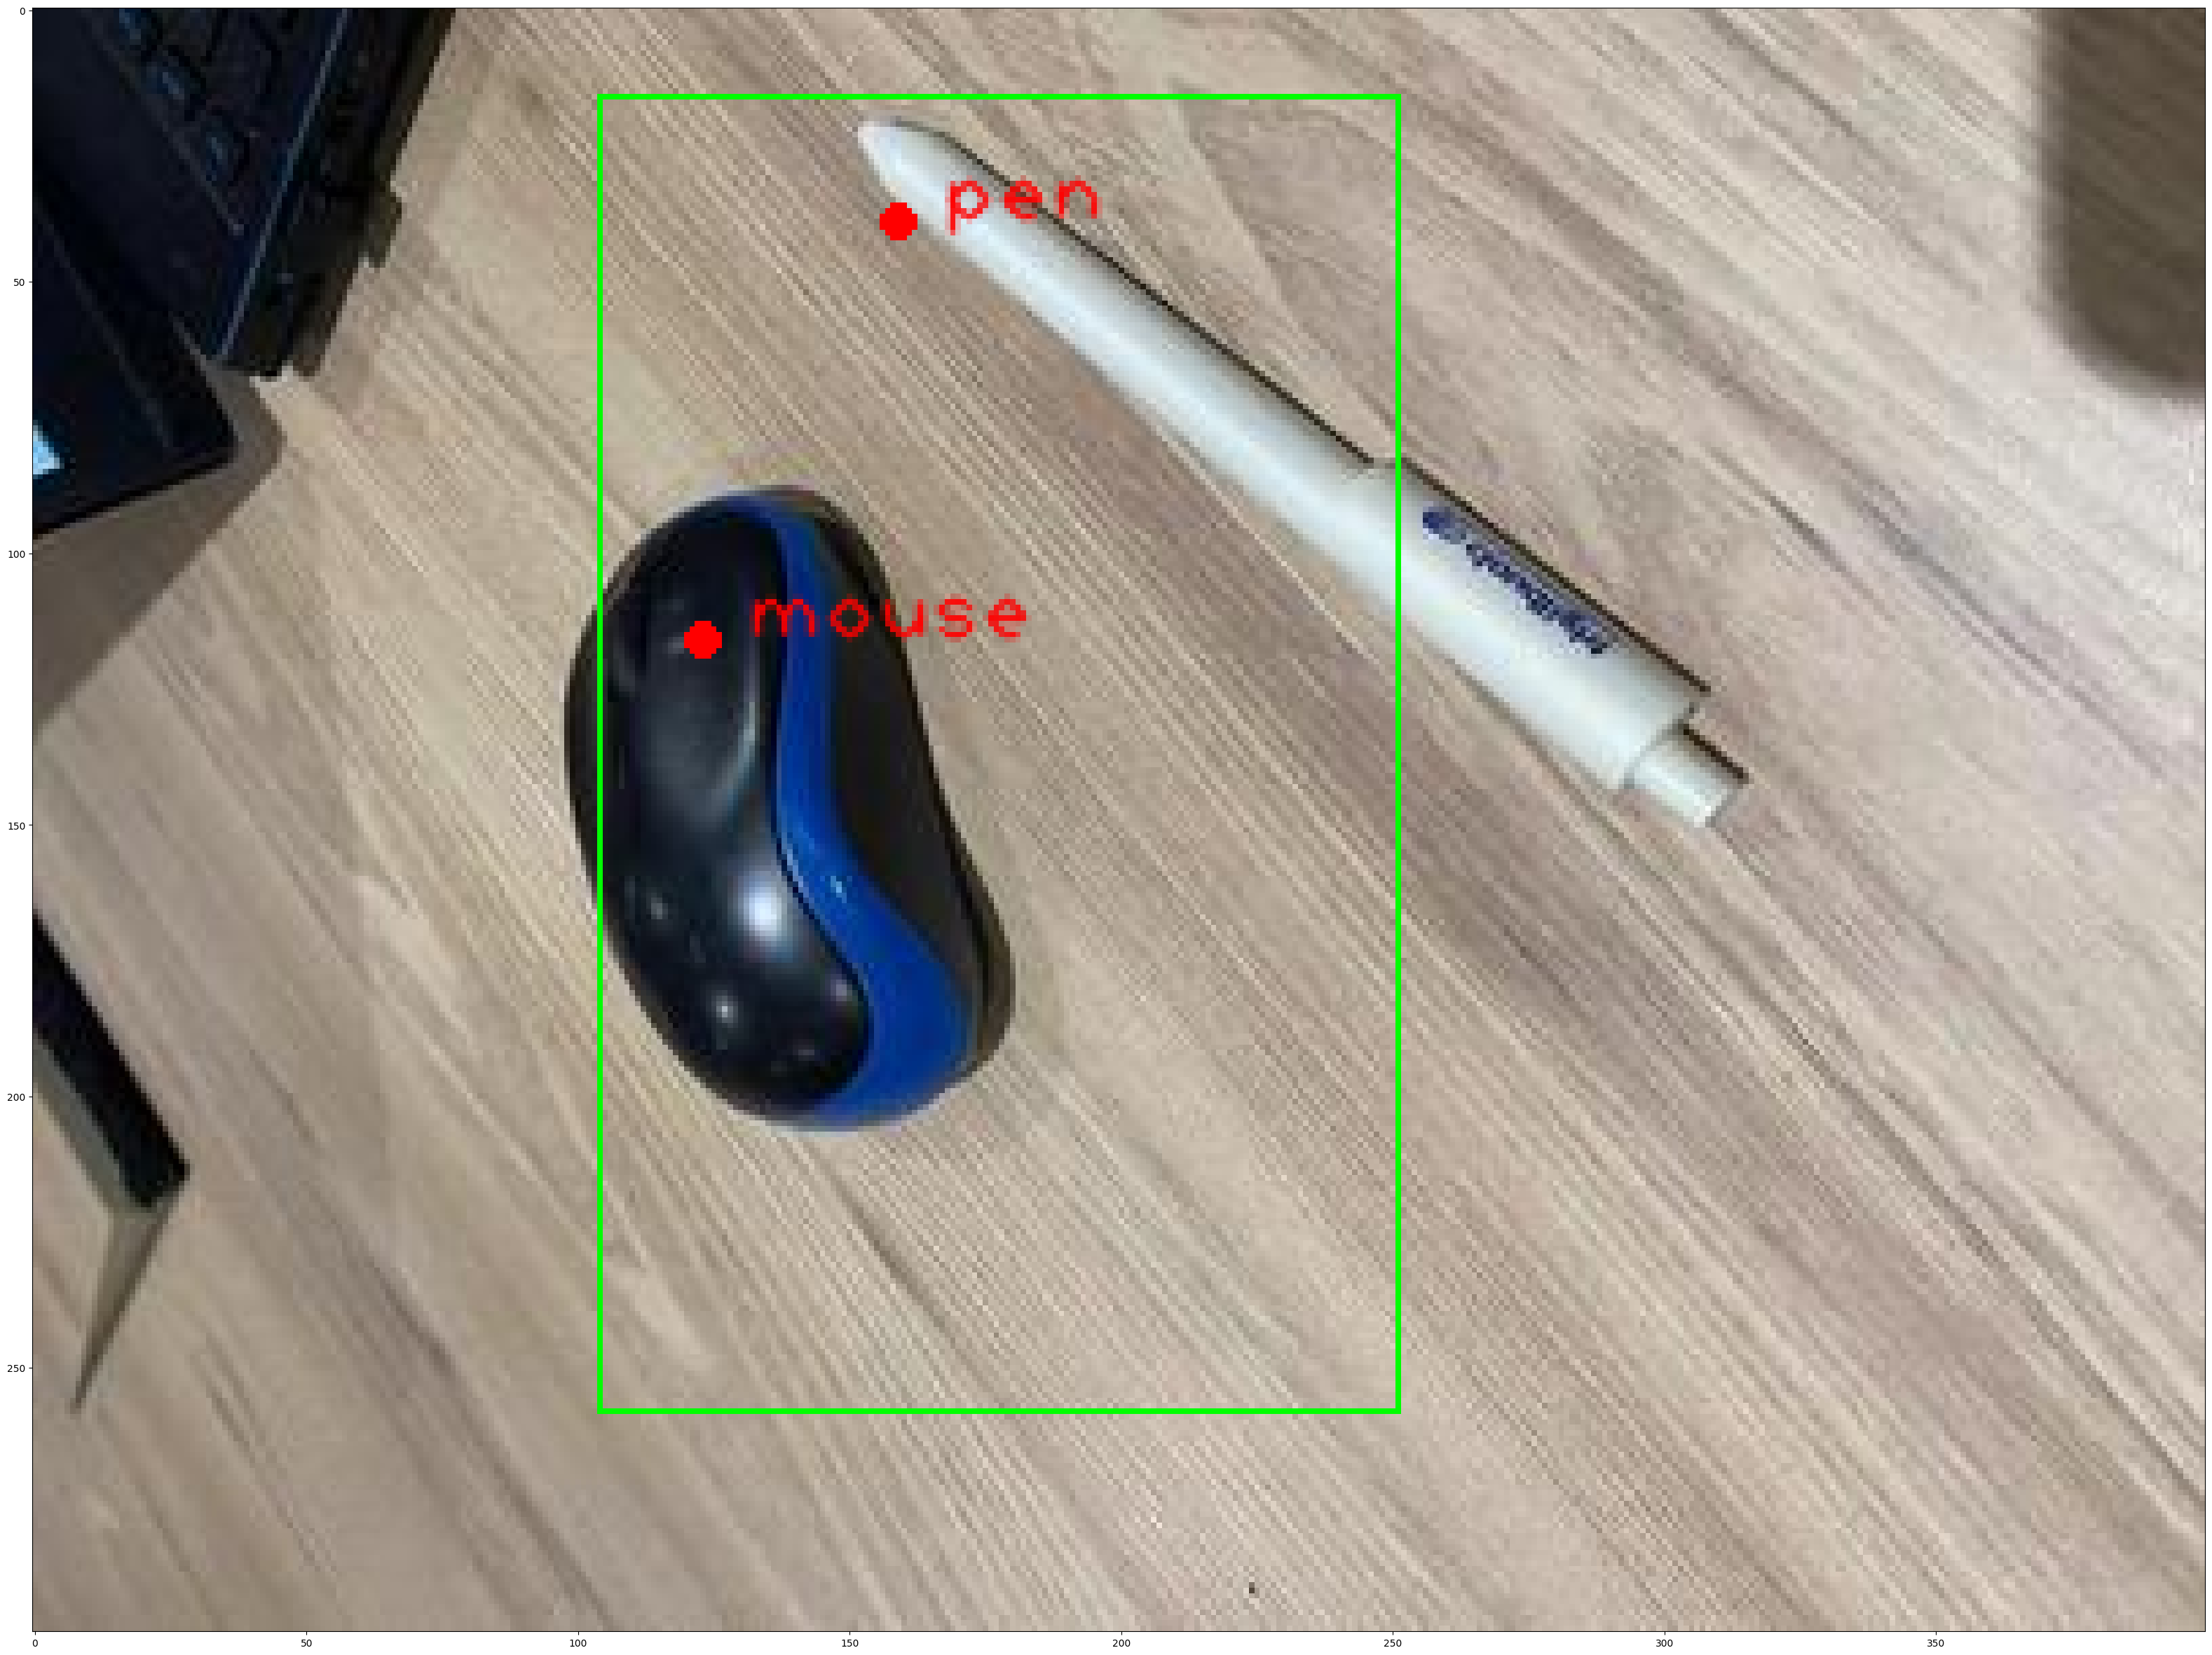

In [ ]:
image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()
print(scores)

high_scores_idxs = np.where(scores > 0.5)[0].tolist() # Indexes of boxes with scores > 0.5
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])
    #if len(keypoints) != 0: #shows only best option
      #break

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
   # if len(bboxes) != 0: #shows only best option
     # break

print(bboxes)

visualize(image, bboxes, keypoints)